
# Import Required Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from keras.regularizers import l2
from sklearn.metrics import classification_report, roc_auc_score
from tensorflow.keras.applications import ResNet50, VGG16, DenseNet169, MobileNetV2, EfficientNetB0
import mediapipe as mp
import warnings
warnings.filterwarnings('ignore')
from keras.models import load_model

# Define the paths of the dataset directories and Labels

In [4]:
# Define the paths to the dataset directories
train_dir = 'D:\\Capstone_MiniProjects_Guvi\\emotional\\dataset\\train'
test_dir = 'D:\\Capstone_MiniProjects_Guvi\\emotional\\dataset\\test'

# Define the emotion labels
emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

# Define hyperparameters, Load and Preprocess Dataset

In [5]:
# Define hyperparameters
BATCH_SIZE = 64
EPOCHS = 30
LEARNING_RATE = 0.001

# Load the dataset function
def load_dataset(directory):
    X = []
    y = []
    for label in emotion_labels:
        label_dir = os.path.join(directory, label)
        for filename in os.listdir(label_dir):
            img_path = os.path.join(label_dir, filename)
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image, (48, 48))
            image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
            X.append(image_rgb)
            y.append(emotion_labels.index(label))
    X = np.array(X)
    y = np.array(y)
    return X, y

# Load and preprocess the data
X_train, y_train = load_dataset(train_dir)
X_test, y_test = load_dataset(test_dir)

# Normalize pixel values to [0, 1]
X_train = X_train / 255.0
X_test = X_test / 255.0

# Convert labels to categorical format
y_train = to_categorical(y_train, num_classes=len(emotion_labels))
y_test = to_categorical(y_test, num_classes=len(emotion_labels))

print(f"Training data shape: {X_train.shape}")  # Should be (num_samples, 48, 48, 3)
print(f"Testing data shape: {X_test.shape}")    # Should be (num_samples, 48, 48, 3)

Training data shape: (28709, 48, 48, 3)
Testing data shape: (7178, 48, 48, 3)


# Plot Dataset Distribution

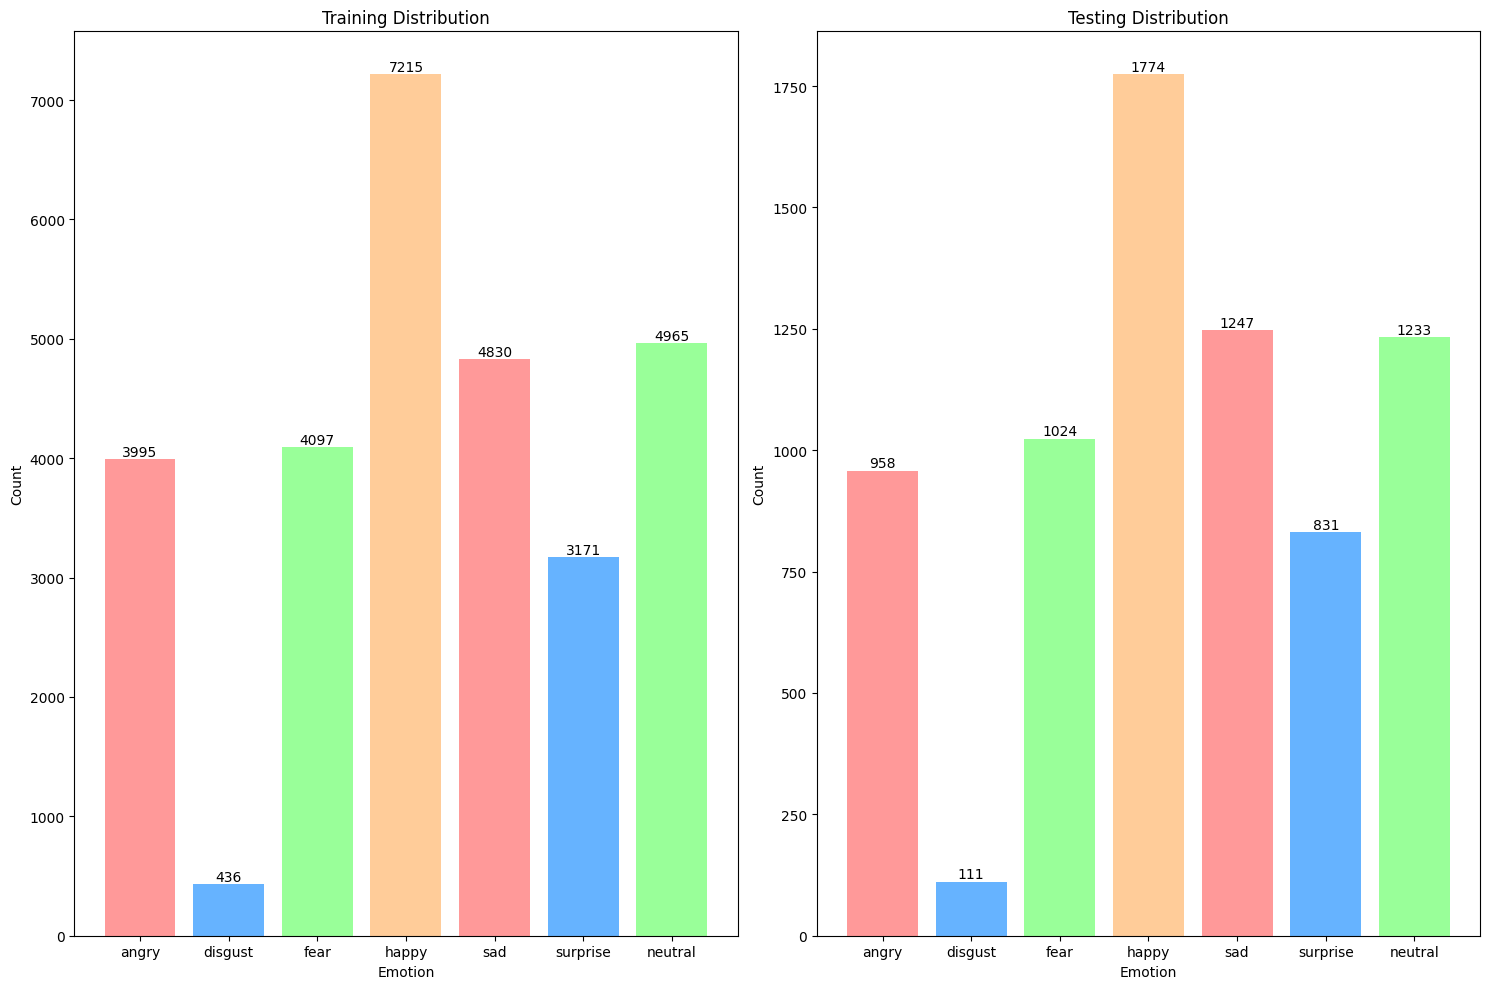

In [6]:
# Function to plot dataset distribution
def plot_dataset_distribution(ax, y, title):
    unique, counts = np.unique(np.argmax(y, axis=1), return_counts=True)    
    # Define colors for each emotion
    colors = ['#FF9999', '#66B3FF', '#99FF99', '#FFCC99']  # Custom color palette
    
    bars = ax.bar(emotion_labels, counts, color=colors)  # Set bar colors
    ax.set_title(title)
    ax.set_xlabel('Emotion')
    ax.set_ylabel('Count')

    # Add value labels on top of each bar
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom')

# Create a figure with subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 10))  # Create a subplot for training and testing distributions

# Plot training dataset distribution
plot_dataset_distribution(axs[0], y_train, 'Training Distribution')

# Plot testing dataset distribution
plot_dataset_distribution(axs[1], y_test, 'Testing Distribution')

# Adjust layout and save the figure
plt.tight_layout()

plt.savefig('D:\Capstone_MiniProjects_Guvi\emotional\image\dataset_distribution.png')  # Save the figure

#plt.close()  # Close the plot to avoid displaying it immediately

# Data Augmentation

In [ ]:
# Enhanced Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Learning Rate

In [ ]:
# Learning Rate Scheduler
def create_lr_scheduler():
    return ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Function to train the model

In [ ]:
# Function to train the model with improved settings
def train_model(model, X_train, y_train, X_test, y_test, batch_size=BATCH_SIZE, epochs=EPOCHS):
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='categorical_crossentropy', metrics=['accuracy'])
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)  # Increased patience
    lr_scheduler = create_lr_scheduler()  # Add learning rate scheduler

    history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                        validation_data=(X_test, y_test),
                        steps_per_epoch=len(X_train) // batch_size,
                        epochs=epochs,
                        callbacks=[early_stopping, lr_scheduler])
    
    return history

# Custom CNN Model

In [ ]:
# Custom CNN Model with L2 Regularization and Batch Normalization
def create_custom_cnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001), input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(num_classes, activation='softmax'))
    
    return model

# Fine-tuning function for pre-trained models

In [ ]:
# Fine-tuning function for pre-trained models
def fine_tune_model(model):
    for layer in model.layers:
        layer.trainable = True  # Unfreeze all layers for fine-tuning

# Densenet Model

In [ ]:
# Transfer Learning Models Creation Functions
def create_densenet_model(input_shape, num_classes):
    base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    for layer in base_model.layers:
        layer.trainable = False
        
    return model

# Resnet Model 

In [ ]:
def create_resnet_model(input_shape,num_classes):
     base_model = ResNet50(weights='imagenet', include_top=False,input_shape=input_shape)
     x = base_model.output
     x = GlobalAveragePooling2D()(x)
     x = Dense(512 ,activation='relu')(x)
     x = Dropout(0.5)(x)
     predictions=Dense(num_classes ,activation='softmax')(x)

     model=Model(inputs=base_model.input ,outputs=predictions)

     for layer in base_model.layers:
         layer.trainable=False

     return model

# VGG Model

In [ ]:
def create_vgg_model(input_shape,num_classes):
     base_model=VGG16(weights='imagenet' ,include_top=False,input_shape=input_shape)
     x=base_model.output 
     x=GlobalAveragePooling2D()(x) 
     x=Dense(512 ,activation='relu')(x) 
     x=Dropout(0.5)(x) 
     predictions=Dense(num_classes ,activation='softmax')(x)

     model=Model(inputs=base_model.input ,outputs=predictions)

     for layer in base_model.layers:
         layer.trainable=False

     return model

# MobileNet Model

In [ ]:
def create_mobilenet_model(input_shape,num_classes):
     base_model=MobileNetV2(weights='imagenet' ,include_top=False,input_shape=input_shape) 
     x=base_model.output 
     x=GlobalAveragePooling2D()(x) 
     x=Dense(512 ,activation='relu')(x) 
     x=Dropout(0.5)(x) 
     predictions=Dense(num_classes ,activation='softmax')(x)

     model=Model(inputs=base_model.input ,outputs=predictions)

     for layer in base_model.layers:
         layer.trainable=False 

     return model

# EfficientNet Model

In [ ]:
def create_efficientnet_model(input_shape,num_classes):
      base_model=EfficientNetB0(weights='imagenet' ,include_top=False,input_shape=input_shape) 
      x=base_model.output 
      x=GlobalAveragePooling2D()(x) 
      x=Dense(512 ,activation='relu')(x) 
      x=Dropout(0.5)(x) 
      predictions=Dense(num_classes ,activation='softmax')(x)

      model=Model(inputs=base_model.input ,outputs=predictions)

      for layer in base_model.layers:
          layer.trainable=False 

      return model

# input shape and number of classes

In [ ]:
# Define input shape and number of classes
input_shape = (48, 48, 3)
num_classes = len(emotion_labels)

# plot training history

In [ ]:
# Function to plot training history
def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{model_name} Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    # Show the plot
    plt.tight_layout()
    
    # Save the plot
    #
    # plt.savefig(f'D:\\Capstone_MiniProjects_Guvi\\Final_Pros\\Emotion-Detection-from-Uploaded-Images-main\\Emotion-Detection-from-Uploaded-Images-main\\emotional\\new\\{model_name.lower()}_training_history.png')
    # plt.savefig(f'D:\Capstone_MiniProjects_Guvi\emotional\new\{model_name.lower()}_training_history.png')
    # plt.show()

    save_path = f'D:\\Capstone_MiniProjects_Guvi\\emotional\\new\\{model_name.lower()}_training_history.png'
    directory = os.path.dirname(save_path) # get the directory path
    if not os.path.exists(directory): # check if the directory exists
        os.makedirs(directory) # create the directory if it does not exist
    plt.savefig(save_path)
    plt.show()

# DenseNet model

Training DenseNet Model...
Epoch 1/30


d:\Capstone_MiniProjects_Guvi\Final_Pros\Emotion-Detection-from-Uploaded-Images-main\Emotion-Detection-from-Uploaded-Images-main\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


448/448 ━━━━━━━━━━━━━━━━━━━━ 88s 173ms/step - accuracy: 0.2746 - loss: 1.8062 - val_accuracy: 0.3514 - val_loss: 1.6485 - learning_rate: 0.0010
Epoch 2/30
  1/448 ━━━━━━━━━━━━━━━━━━━━ 55s 123ms/step - accuracy: 0.3438 - loss: 1.7081

d:\Capstone_MiniProjects_Guvi\Final_Pros\Emotion-Detection-from-Uploaded-Images-main\Emotion-Detection-from-Uploaded-Images-main\.venv\lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


448/448 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - accuracy: 0.3438 - loss: 1.7081 - val_accuracy: 0.3472 - val_loss: 1.6481 - learning_rate: 0.0010
Epoch 3/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 73s 162ms/step - accuracy: 0.3250 - loss: 1.6884 - val_accuracy: 0.3615 - val_loss: 1.6235 - learning_rate: 0.0010
Epoch 4/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - accuracy: 0.4219 - loss: 1.5984 - val_accuracy: 0.3617 - val_loss: 1.6243 - learning_rate: 0.0010
Epoch 5/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 74s 166ms/step - accuracy: 0.3347 - loss: 1.6723 - val_accuracy: 0.3424 - val_loss: 1.6412 - learning_rate: 0.0010
Epoch 6/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - accuracy: 0.3281 - loss: 1.6179 - val_accuracy: 0.3462 - val_loss: 1.6355 - learning_rate: 0.0010
Epoch 7/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 74s 164ms/step - accuracy: 0.3413 - loss: 1.6617 - val_accuracy: 0.3729 - val_loss: 1.6033 - learning_rate: 0.0010
Epoch 8/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.4062 - loss: 1.4

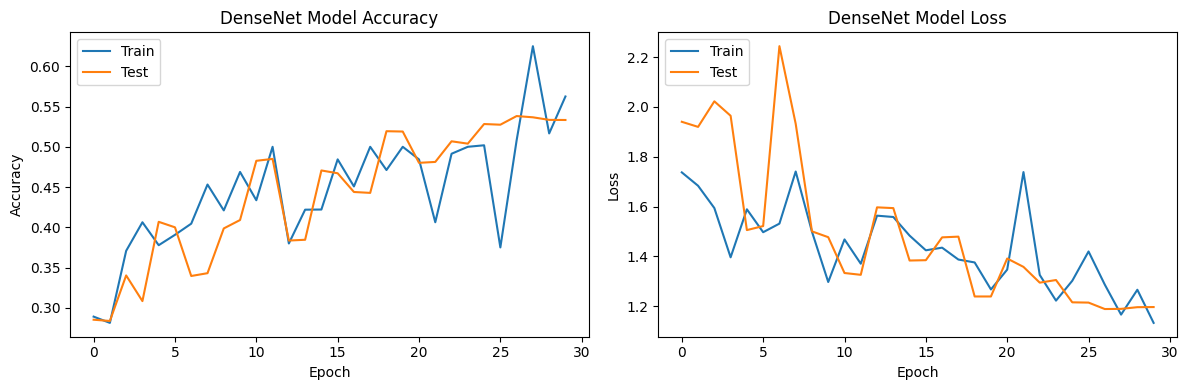

In [ ]:
# Create and train DenseNet model
def train_densenet_model():
    densenet_model = create_densenet_model(input_shape, num_classes)
    print("Training DenseNet Model...")
    pretrained_history = train_model(densenet_model, X_train, y_train, X_test, y_test)
    fine_tune_model(densenet_model)
    pretrained_history_fine_tune = train_model(densenet_model, X_train, y_train, X_test, y_test)
    
    # Plot training history for DenseNet
    plot_training_history(pretrained_history_fine_tune, "DenseNet")

     # Save the trained model
    #model_save_path = 'D:\\Capstone_MiniProjects_Guvi\\Final_Pros\\Emotion-Detection-from-Uploaded-Images-main\\Emotion-Detection-from-Uploaded-Images-main\\emotional\\image\\densenet_model.keras'  # Specify your desired file path
    model_save_path = 'D:\Capstone_MiniProjects_Guvi\emotional\image\densenet_model.keras'  # Specify your desired file path
    densenet_model.save(model_save_path)
    
    return densenet_model, pretrained_history, pretrained_history_fine_tune

densenet_model ,densenet_history ,densenet_history_fine_tune=train_densenet_model()

# ResNet model

Training ResNet Model...
Epoch 1/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 176s 379ms/step - accuracy: 0.2279 - loss: 1.8863 - val_accuracy: 0.2471 - val_loss: 1.8131 - learning_rate: 0.0010
Epoch 2/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 37s 83ms/step - accuracy: 0.2656 - loss: 1.7789 - val_accuracy: 0.2471 - val_loss: 1.8133 - learning_rate: 0.0010
Epoch 3/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 160s 357ms/step - accuracy: 0.2523 - loss: 1.8237 - val_accuracy: 0.2471 - val_loss: 1.8135 - learning_rate: 0.0010
Epoch 4/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 36s 80ms/step - accuracy: 0.2500 - loss: 1.8626 - val_accuracy: 0.2471 - val_loss: 1.8146 - learning_rate: 0.0010
Epoch 5/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 160s 356ms/step - accuracy: 0.2475 - loss: 1.8207 - val_accuracy: 0.2473 - val_loss: 1.8087 - learning_rate: 0.0010
Epoch 6/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 37s 82ms/step - accuracy: 0.2969 - loss: 1.6963 - val_accuracy: 0.2471 - val_loss: 1.8087 - learning_rate: 0.0010
Epoch 7/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 162s 

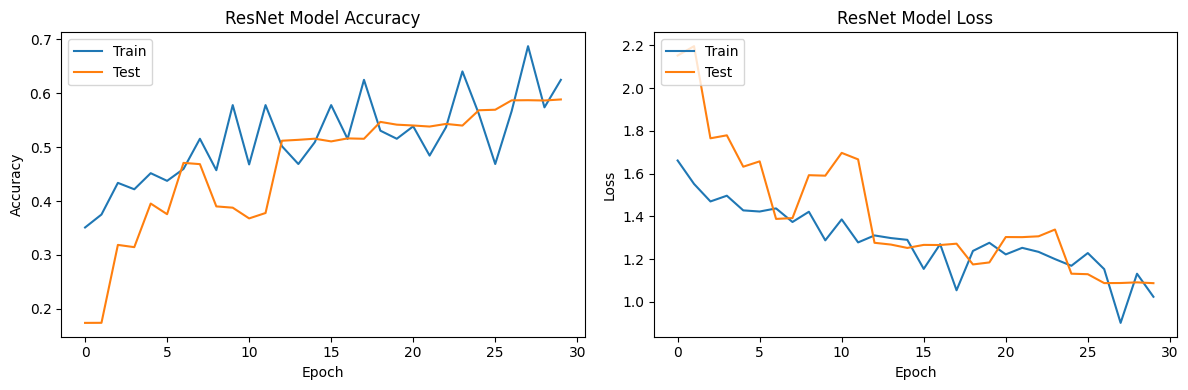

In [ ]:
# Create and train ResNet model  
def train_resnet_model():
    resnet_model = create_resnet_model(input_shape, num_classes)
    print("Training ResNet Model...")
    pretrained_history = train_model(resnet_model, X_train, y_train, X_test, y_test)
    fine_tune_model(resnet_model)
    pretrained_history_fine_tune = train_model(resnet_model, X_train, y_train, X_test, y_test)

    # Plot training history for ResNet
    plot_training_history(pretrained_history_fine_tune, "ResNet")

     # Save the trained model
    model_save_path = r'D:\Capstone_MiniProjects_Guvi\emotional\image\resnet_model.keras'  # Specify your desired file path
    resnet_model.save(model_save_path)
   
    return resnet_model, pretrained_history, pretrained_history_fine_tune

resnet_model ,resnet_history ,resnet_history_fine_tune=train_resnet_model()


# VGG model

Training VGG Model...
Epoch 1/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 117s 259ms/step - accuracy: 0.2666 - loss: 1.8033 - val_accuracy: 0.3431 - val_loss: 1.6442 - learning_rate: 0.0010
Epoch 2/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 23s 52ms/step - accuracy: 0.3594 - loss: 1.6300 - val_accuracy: 0.3395 - val_loss: 1.6452 - learning_rate: 0.0010
Epoch 3/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 310s 693ms/step - accuracy: 0.3116 - loss: 1.7097 - val_accuracy: 0.3480 - val_loss: 1.6319 - learning_rate: 0.0010
Epoch 4/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 23s 52ms/step - accuracy: 0.4219 - loss: 1.5811 - val_accuracy: 0.3469 - val_loss: 1.6295 - learning_rate: 0.0010
Epoch 5/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 114s 254ms/step - accuracy: 0.3228 - loss: 1.6884 - val_accuracy: 0.3391 - val_loss: 1.6421 - learning_rate: 0.0010
Epoch 6/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 24s 53ms/step - accuracy: 0.2656 - loss: 1.7497 - val_accuracy: 0.3385 - val_loss: 1.6417 - learning_rate: 0.0010
Epoch 7/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 381s 851

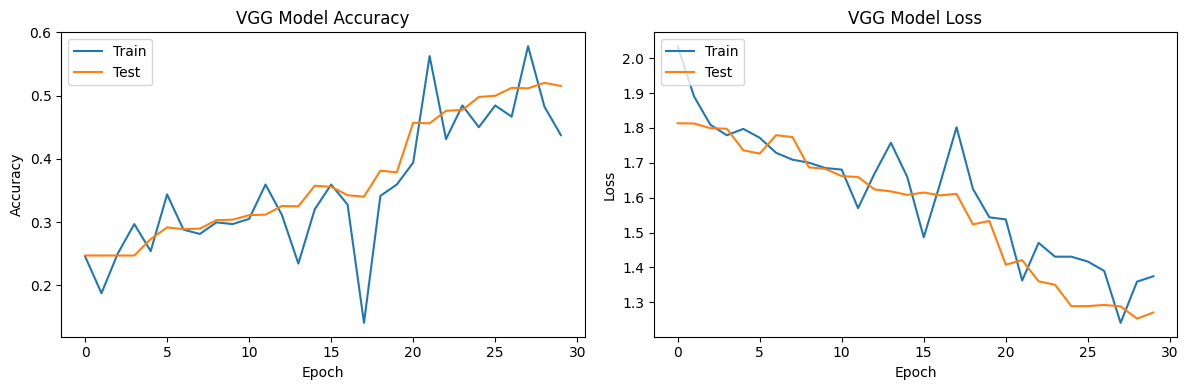

In [ ]:
# Create and train VGG model
def train_vgg_model():
    vgg_model = create_vgg_model(input_shape, num_classes)
    print("Training VGG Model...")
    pretrained_history = train_model(vgg_model, X_train, y_train, X_test, y_test)
    fine_tune_model(vgg_model)
    pretrained_history_fine_tune = train_model(vgg_model, X_train, y_train, X_test, y_test)

    # Plot training history for VGG
    plot_training_history(pretrained_history_fine_tune, "VGG")

     # Save the trained model
    model_save_path = r'D:\Capstone_MiniProjects_Guvi\emotional\image\vgg_model.keras'  # Specify your desired file path
    vgg_model.save(model_save_path)

    return vgg_model, pretrained_history, pretrained_history_fine_tune

vgg_model ,vgg_history ,vgg_history_fine_tune=train_vgg_model()

# MobileNet model

C:\Users\Karthik\AppData\Local\Temp\ipykernel_26396\2006798684.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model=MobileNetV2(weights='imagenet' ,include_top=False,input_shape=input_shape)


Training MobileNet Model...
Epoch 1/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 51s 106ms/step - accuracy: 0.2621 - loss: 1.9108 - val_accuracy: 0.3196 - val_loss: 1.6782 - learning_rate: 0.0010
Epoch 2/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.3125 - loss: 1.7669 - val_accuracy: 0.3196 - val_loss: 1.6803 - learning_rate: 0.0010
Epoch 3/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - accuracy: 0.3101 - loss: 1.7093 - val_accuracy: 0.3334 - val_loss: 1.6499 - learning_rate: 0.0010
Epoch 4/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.2812 - loss: 1.6799 - val_accuracy: 0.3309 - val_loss: 1.6518 - learning_rate: 0.0010
Epoch 5/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 48s 107ms/step - accuracy: 0.3165 - loss: 1.6992 - val_accuracy: 0.3201 - val_loss: 1.6690 - learning_rate: 0.0010
Epoch 6/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.4219 - loss: 1.5130 - val_accuracy: 0.3186 - val_loss: 1.6713 - learning_rate: 0.0010
Epoch 7/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 49s 108m

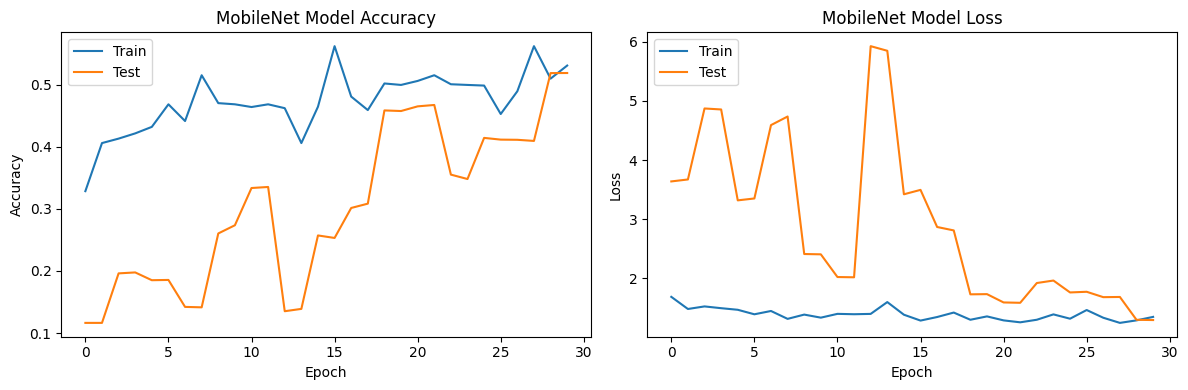

In [ ]:
# Create and train MobileNet model
def train_mobilenet_model():
    mobilenet_model = create_mobilenet_model(input_shape, num_classes)
    print("Training MobileNet Model...")
    pretrained_history = train_model(mobilenet_model, X_train, y_train, X_test, y_test)
    fine_tune_model(mobilenet_model)
    pretrained_history_fine_tune = train_model(mobilenet_model, X_train, y_train, X_test, y_test)

    # Plot training history for MobileNet 
    plot_training_history(pretrained_history_fine_tune, "MobileNet")

     # Save the trained model
    model_save_path = r'D:\Capstone_MiniProjects_Guvi\emotional\image\mobilenet_model.keras'  # Specify your desired file path
    mobilenet_model.save(model_save_path)

    return mobilenet_model, pretrained_history, pretrained_history_fine_tune

mobilenet_model ,mobilenet_history ,mobilenet_history_fine_tune=train_mobilenet_model()

# EfficientNet model

Training EfficientNet Model...
Epoch 1/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 104s 217ms/step - accuracy: 0.2253 - loss: 1.8582 - val_accuracy: 0.2471 - val_loss: 1.8167 - learning_rate: 0.0010
Epoch 2/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.2500 - loss: 1.7987 - val_accuracy: 0.2471 - val_loss: 1.8166 - learning_rate: 0.0010
Epoch 3/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 96s 214ms/step - accuracy: 0.2532 - loss: 1.8204 - val_accuracy: 0.2471 - val_loss: 1.8152 - learning_rate: 0.0010
Epoch 4/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.1875 - loss: 1.8366 - val_accuracy: 0.2471 - val_loss: 1.8152 - learning_rate: 0.0010
Epoch 5/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 97s 215ms/step - accuracy: 0.2531 - loss: 1.8159 - val_accuracy: 0.2471 - val_loss: 1.8141 - learning_rate: 0.0010
Epoch 6/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.1094 - loss: 1.9579 - val_accuracy: 0.2471 - val_loss: 1.8141 - learning_rate: 0.0010
Epoch 7/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 9

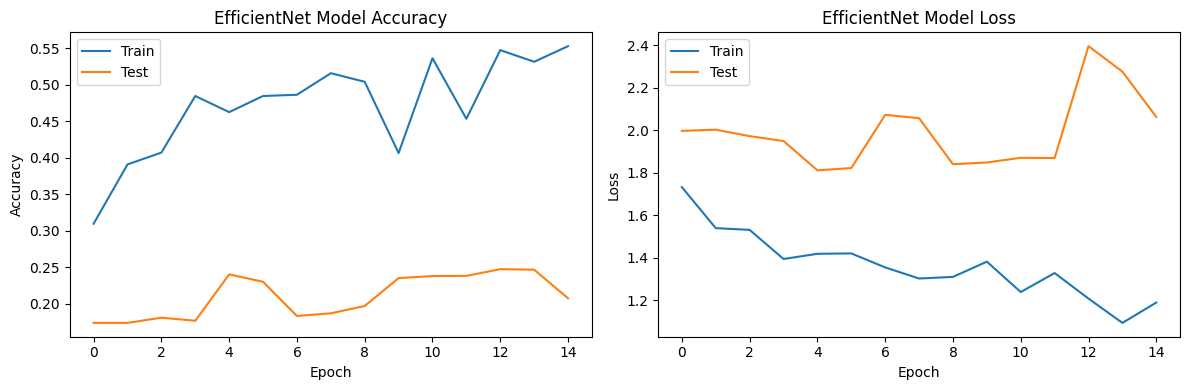

In [ ]:
# Create and train EfficientNet model
def train_efficientnet_model():
    efficientnet_model = create_efficientnet_model(input_shape, num_classes)
    print("Training EfficientNet Model...")
    pretrained_history = train_model(efficientnet_model, X_train, y_train, X_test, y_test)
    fine_tune_model(efficientnet_model)
    pretrained_history_fine_tune = train_model(efficientnet_model, X_train, y_train, X_test, y_test)

    # Plot training history for EfficientNet
    plot_training_history(pretrained_history_fine_tune,"EfficientNet")

     # Save the trained model
    model_save_path = r'D:\Capstone_MiniProjects_Guvi\emotional\image\efficientnet_model.keras'  # Specify your desired file path
    efficientnet_model.save(model_save_path)

    return efficientnet_model ,pretrained_history ,pretrained_history_fine_tune

    
efficientnet_model ,efficientnet_history ,efficientnet_history_fine_tune=train_efficientnet_model()

# Custom CNN model

d:\Capstone_MiniProjects_Guvi\Final_Pros\Emotion-Detection-from-Uploaded-Images-main\Emotion-Detection-from-Uploaded-Images-main\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training Custom CNN Model...
Epoch 1/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 60s 128ms/step - accuracy: 0.1903 - loss: 3.1884 - val_accuracy: 0.1722 - val_loss: 2.7581 - learning_rate: 0.0010
Epoch 2/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.2188 - loss: 2.4723 - val_accuracy: 0.1758 - val_loss: 2.7338 - learning_rate: 0.0010
Epoch 3/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 56s 126ms/step - accuracy: 0.2319 - loss: 2.4885 - val_accuracy: 0.2848 - val_loss: 2.2649 - learning_rate: 0.0010
Epoch 4/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.2500 - loss: 2.3620 - val_accuracy: 0.2834 - val_loss: 2.2629 - learning_rate: 0.0010
Epoch 5/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 56s 126ms/step - accuracy: 0.2570 - loss: 2.2810 - val_accuracy: 0.2842 - val_loss: 2.1309 - learning_rate: 0.0010
Epoch 6/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.3125 - loss: 2.1644 - val_accuracy: 0.2852 - val_loss: 2.1287 - learning_rate: 0.0010
Epoch 7/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 63s 141ms/

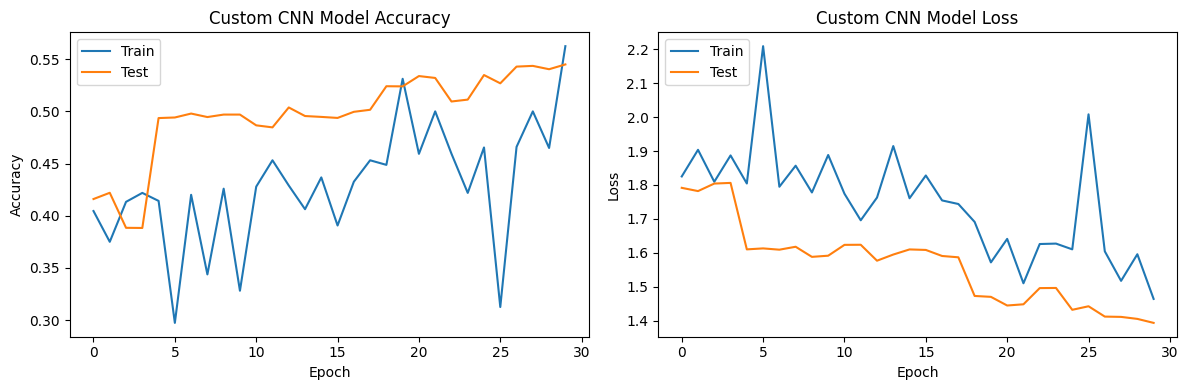

In [ ]:
# Create and train Custom CNN model with fine-tuning
def train_custom_cnn_model():
    custom_cnn_model = create_custom_cnn_model(input_shape, num_classes)
    print("Training Custom CNN Model...")
    
    # Train the model initially
    pretrained_history = train_model(custom_cnn_model, X_train, y_train, X_test, y_test)
    
    # Fine-tune the model
    fine_tune_model(custom_cnn_model)
    
    # Retrain the model after fine-tuning
    pretrained_history_fine_tune = train_model(custom_cnn_model, X_train, y_train, X_test, y_test)

    # Plot training history for Custom CNN
    plot_training_history(pretrained_history_fine_tune, "Custom CNN")

    # Save the trained model
    model_save_path = r'D:\Capstone_MiniProjects_Guvi\emotional\image\custom_cnn_model.keras'  # Specify your desired file path
    custom_cnn_model.save(model_save_path)

    return custom_cnn_model, pretrained_history, pretrained_history_fine_tune

# Train and fine-tune Custom CNN Model
custom_cnn_model, custom_cnn_history, custom_cnn_history_fine_tune = train_custom_cnn_model()

# evaluate performance metrics

In [ ]:
# Function to evaluate performance metrics including ROC AUC score
def evaluate_model(model, X_test, y_test):
    loss, accuracy = model.evaluate(X_test, y_test)
    predictions = model.predict(X_test)
    predicted_classes = np.argmax(predictions, axis=1)

    # Ensure y_test_classes is correctly formatted
    y_test_classes = np.argmax(y_test, axis=1) if y_test.ndim > 1 else y_test 

    report = classification_report(y_test_classes, predicted_classes, zero_division=1)
    roc_auc = roc_auc_score(y_test, predictions, multi_class='ovr')
    
    return loss, accuracy, report, roc_auc

# model file paths

In [ ]:
model_paths = [
    r'D:\Capstone_MiniProjects_Guvi\emotional\image\densenet_model.keras',
    r'D:\Capstone_MiniProjects_Guvi\emotional\image\efficientnet_model.keras',
    r'D:\Capstone_MiniProjects_Guvi\emotional\image\mobilenet_model.keras',
    r'D:\Capstone_MiniProjects_Guvi\emotional\image\resnet_model.keras',
    r'D:\Capstone_MiniProjects_Guvi\emotional\image\vgg_model.keras',
    r'D:\Capstone_MiniProjects_Guvi\emotional\image\custom_cnn_model.keras'
]

In [ ]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Keras version:", tf.keras.__version__)

TensorFlow version: 2.19.0
Keras version: 3.9.2


In [ ]:
# List of model file paths
model_paths = [
    r"C:/Guvi Projects/emotional/image/densenet_model.keras",
    r"C:/Guvi Projects/emotional/image/efficientnet_model.keras",
    r"C:/Guvi Projects/emotional/image/mobilenet_model.keras",
    r"C:/Guvi Projects/emotional/image/resnet_model.keras",
    r"C:/Guvi Projects/emotional/image/vgg_model.keras",
    r"C:/Guvi Projects/emotional/image/custom_cnn_model.keras"
]

In [ ]:
# Evaluate all models and store results
results = {}

for model_path in model_paths:
    print(f"Loading model from {model_path}...")
    model = load_model(model_path)
    
    print("Evaluating model...")
    loss, accuracy, report, roc_auc = evaluate_model(model, X_test, y_test)
    
    # Store results in a dictionary
    results[model_path] = {
        'loss': loss,
        'accuracy': accuracy,
        'classification_report': report,
        'roc_auc': roc_auc
    }
    
    print(f"Model: {model_path}")
    print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}, ROC AUC: {roc_auc:.4f}")
    print(report)


Loading model from D:\Capstone_MiniProjects_Guvi\emotional\image\densenet_model.keras...
Evaluating model...
225/225 ━━━━━━━━━━━━━━━━━━━━ 55s 217ms/step - accuracy: 0.4375 - loss: 1.3161
225/225 ━━━━━━━━━━━━━━━━━━━━ 58s 245ms/step
Model: D:\Capstone_MiniProjects_Guvi\emotional\image\densenet_model.keras
Loss: 1.1892, Accuracy: 0.5382, ROC AUC: 0.8403
              precision    recall  f1-score   support

           0       0.38      0.41      0.40       958
           1       1.00      0.00      0.00       111
           2       0.33      0.08      0.13      1024
           3       0.79      0.84      0.82      1774
           4       0.37      0.39      0.38      1247
           5       0.69      0.69      0.69       831
           6       0.45      0.67      0.54      1233

    accuracy                           0.54      7178
   macro avg       0.57      0.44      0.42      7178
weighted avg       0.53      0.54      0.51      7178

Loading model from D:\Capstone_MiniProjects_Guvi\e

# best performing model based on accuracy

In [ ]:
# Determine best performing model based on accuracy
best_model_path = max(results.keys(), key=lambda k: results[k]['accuracy'])
best_performance = results[best_model_path]

print("\nBest Performing Model:")
print(f"Model Path: {best_model_path}")
print(f"Loss: {best_performance['loss']:.4f}, Accuracy: {best_performance['accuracy']:.4f}, ROC AUC: {best_performance['roc_auc']:.4f}")


Best Performing Model:
Model Path: D:\Capstone_MiniProjects_Guvi\emotional\image\resnet_model.keras
Loss: 1.0881, Accuracy: 0.5886, ROC AUC: 0.8778
